In [4]:
import ast
import colorsys
import json
import cv2
import os
import multiprocessing as mp
import open3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dl.utils.io_utils import normalize_image
from dl.utils.image_transforms import depth_from_point_cloud
from dl.utils.config import DEFAULT_TONEMAP_PARAMS


In [7]:
from brtdevkit.data import Dataset
dset =Dataset.retrieve(name='halo_all_cam_images_3_seconds_2_sequences')
df = dset.to_dataframe()

2023-11-27 12:56:22,316 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt


In [9]:
df['id']

0      64d4f086c28c73a940149ae9
1      64d4f0874210b6d080e0fe38
2      64d4f0897b4fe49221d88a05
3      64d4f08b39450239bc10df3f
4      64d4f08c84dac3a508c41d03
                 ...           
115    64ee62db5e01413330f18904
116    64ee62dd880764ea65c3386d
117    64ee62de22fae285992a5c9b
118    64ee62e0b5783f9f881ebdfd
119    64ee62e245f3f1852140b76d
Name: id, Length: 120, dtype: object

In [10]:
from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import imageids_to_dataset
imageids_to_dataset(df['id'], 'halo_all_cam_anno_3_seconds_2_sequences', dset.description)

2023-11-27 12:57:41,630 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt


Total annotations retrieved from athena 87
Removed annotations in state SKIP, 87 left
Filtered 8 annotations with non-production label map.
Removed annotations if the label map is not the stanadard production one, 79 left
Removed duplicate annotations for the same image (choosing latest), 59 left
Warning 61 images do not have a corresponding annotation.
Preparing stereo dataframe for {'T01': 'T03', 'T02': 'T04', 'T05': 'T07', 'T06': 'T08', 'T09': 'T11', 'T10': 'T12', 'T13': 'T15', 'T14': 'T16', 'I01': 'I03', 'I02': 'I04'}...
Size of left dataframe: 59


2023-11-27 12:58:00,689 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt
2023-11-27 12:58:12,480 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt
2023-11-27 12:58:24,994 - APIRequestor - ERROR - API error received | error_code : 403, erro

Size of stereo dataframe: 59
Preparing stereo dataframe for {'T02': 'T03', 'T06': 'T07', 'T10': 'T11', 'T14': 'T15', 'I02': 'I03'}...
Size of left dataframe: 29


2023-11-27 13:00:08,298 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt
2023-11-27 13:00:23,672 - APIRequestor - ERROR - API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
ERROR:APIRequestor:API error received | error_code : 403, error_message : {'extra': {'role_name': 'token_exchange'}, 'message': 'Role token_exchange is required to make this API call'}
INFO:botocore.tokens:Loading cached SSO token for brt
2023-11-27 13:00:37,502 - APIRequestor - ERROR - API error received | error_code : 403, erro

Size of stereo dataframe: 29
Sending 59 annotated_ids for creating dataset
Time taken to prepare data for dataset creation job: 3.58 mins


In [8]:
directory_list = [f"{os.environ['DATASET_PATH']}/halo_all_cam_images_3_seconds_2_sequences",
             f'{os.environ["DATASET_PATH"]}/halo_all_cam_labeled_dataset',
             '/data2/jupiter/datasets/20231017_halo_rgb_labeled_excluded_bad_iq',
             '/data/jupiter/datasets/iq_2023_v5_anno']
csv_list = [
    'annotations.csv',
    'master_annotations.csv',
    '653a7a0a3c2d8ab221f6d915_master_annotations.csv',
    '64dfcc1de5a41169c7deb205_master_annotations.csv']
dataset_idx = 1
directory = directory_list[dataset_idx]
csv_name = csv_list[dataset_idx]
dset_name = directory.split('/')[-1]
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
stereo_df_uniq = stereo_df_full.drop_duplicates('id')
# example_ids = ['64e6934deef031aa465115f3']
stereo_df = stereo_df_uniq[stereo_df_uniq['group_id'].isin(['b1662dfb57b04a15881c9673a880e053'])]
print(len(stereo_df))
stereo_df_uniq.groupby('group_id').count()

4


,Unnamed: 0,actor_clothing,actor,annotation_pixelwise_0__cls,annotation_pixelwise_0__id,annotation_pixelwise_0_annotation_job,annotation_pixelwise_0_audit_mistake_found,annotation_pixelwise_0_audit_mistakes,annotation_pixelwise_0_audit_requested,annotation_pixelwise_0_created_at,...,rectified_label_save_path,rectified_stereo_output_height,rectified_stereo_output_width,script_id,stereo_left_image,stereo_pipeline_npz_save_path,stereo_right_image,unique_id,is_good_data,ocal_passed
group_id,,,,,,,,,,,,,,,,,,,,,
6660d0d2301a46c1870f15e188b15ffa,4,0,0,4,4,4,4,4,4,4,...,4,4,4,0,4,4,4,4,4,4
ac2122103bf04dccbf593122a3f9dacf,4,0,0,4,4,4,4,4,4,4,...,4,4,4,0,4,4,4,4,4,4
b1662dfb57b04a15881c9673a880e053,4,0,0,4,4,4,4,4,4,4,...,4,4,4,0,4,4,4,4,4,4
c34833afe7a24f8cab83c706414a173a,4,4,4,4,4,4,4,4,4,4,...,4,4,4,0,4,4,4,4,4,4


In [18]:
# Get N visually distinct colors
def get_distinct_colors(n):
    colors = []
    for h in np.arange(0., 1., 1. / n):
        r, g, b = [int(255 * c) for c in colorsys.hsv_to_rgb(h, 1, 1)]
        colors.append((r, g, b))
    return colors
def list_to_plotly_color(rgb_color) -> str:
    # Convert a list [17, 157, 255] to plotly color 'rgb(17, 157, 255)'
    return f"rgb({rgb_color[0]}, {rgb_color[1]}, {rgb_color[2]})"
#http://www.open3d.org/docs/latest/tutorial/Advanced/multiway_registration.html
def pairwise_registration(source, target, max_correspondence_distance_fine, max_correspondence_distance_coarse):
    print("Apply point-to-plane ICP")
    icp_coarse = open3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        open3d.pipelines.registration.TransformationEstimationPointToPlane())
    icp_fine = open3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        open3d.pipelines.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = open3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp
def full_registration(pcds,max_correspondence_distance_fine, max_correspondence_distance_coarse):
    pose_graph = open3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(open3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id], max_correspondence_distance_fine, max_correspondence_distance_coarse)
            print("Build o3d.pipelines.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    open3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    open3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    open3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    print("Optimizing PoseGraph ...")
    option = open3d.pipelines.registration.GlobalOptimizationOption(
        max_correspondence_distance=max_correspondence_distance_fine,
        edge_prune_threshold=0.25,
        reference_node=0)
    open3d.pipelines.registration.global_optimization(
        pose_graph,
        open3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
        open3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
        option)
    return pose_graph

In [19]:
def load_object(row, get_label=False):
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    label_file_names = [f for f in os.listdir(folder_path) if 'stereo' not in f]
    file_names = sorted([f for f in os.listdir(folder_path) if 'stereo' in f])
    camss = [tuple(n.strip('.npz').split('_')[-2::]) for n in file_names]
    result = []
    for file_name, cams in zip(file_names, camss):
        image_npz = np.load(folder_path + file_name, allow_pickle=True)
        if get_label:
            label_file = None
            for lf in label_file_names:
                if lf.endswith(f"{cams[0]}_{cams[1]}.npz"):
                    label_file = lf
            assert label_file is not None
            label = np.load(folder_path + label_file)['left']
            result.append((image_npz, cams, label))
        else:
            result.append((image_npz, cams))
    return result

def show_images(df):
    assert len(df) < 100, "Bro, too many images"
    n, m = len(df), 5
    fig, ax = plt.subplots(n, m, figsize=(m * 3.2, n * 4), squeeze=False)
    for i, (_, row) in enumerate(df.iterrows()):
        objs = load_object(row)
        obj, cams = objs[0]
        im_l = normalize_image(obj['left'], row['hdr_mode'])
        ax[i][0].set_title(cams[0])
        ax[i][0].imshow(im_l)

        im_r = normalize_image(obj['right'], row['hdr_mode'])
        ax[i][1].set_title(cams[1])
        ax[i][1].imshow(im_r)

        im_depth = obj['point_cloud'][..., 2] / 100
        ax[i][3].set_title(f"{'_'.join(cams)} depth")
        ax[i][3].imshow(im_depth)
        if len(objs) > 1:
            assert len(objs) == 2
            other_obj, other_cams = objs[1]
            if other_cams[0] in cams:
                assert other_cams[1] not in cams
                other_cam = other_cams[1]
                other_img = normalize_image(other_obj['right'], row['hdr_mode'])
            else:
                assert other_cams[1] in cams
                other_cam = other_cams[0]
                other_img = normalize_image(other_obj['left'], row['hdr_mode'])
            ax[i][2].set_title(other_cam)
            ax[i][2].imshow(other_img)

            other_depth = other_obj['point_cloud'][..., 2] / 100
            ax[i][4].set_title(f"{'_'.join(other_cams)}_depth")
            ax[i][4].imshow(other_depth)


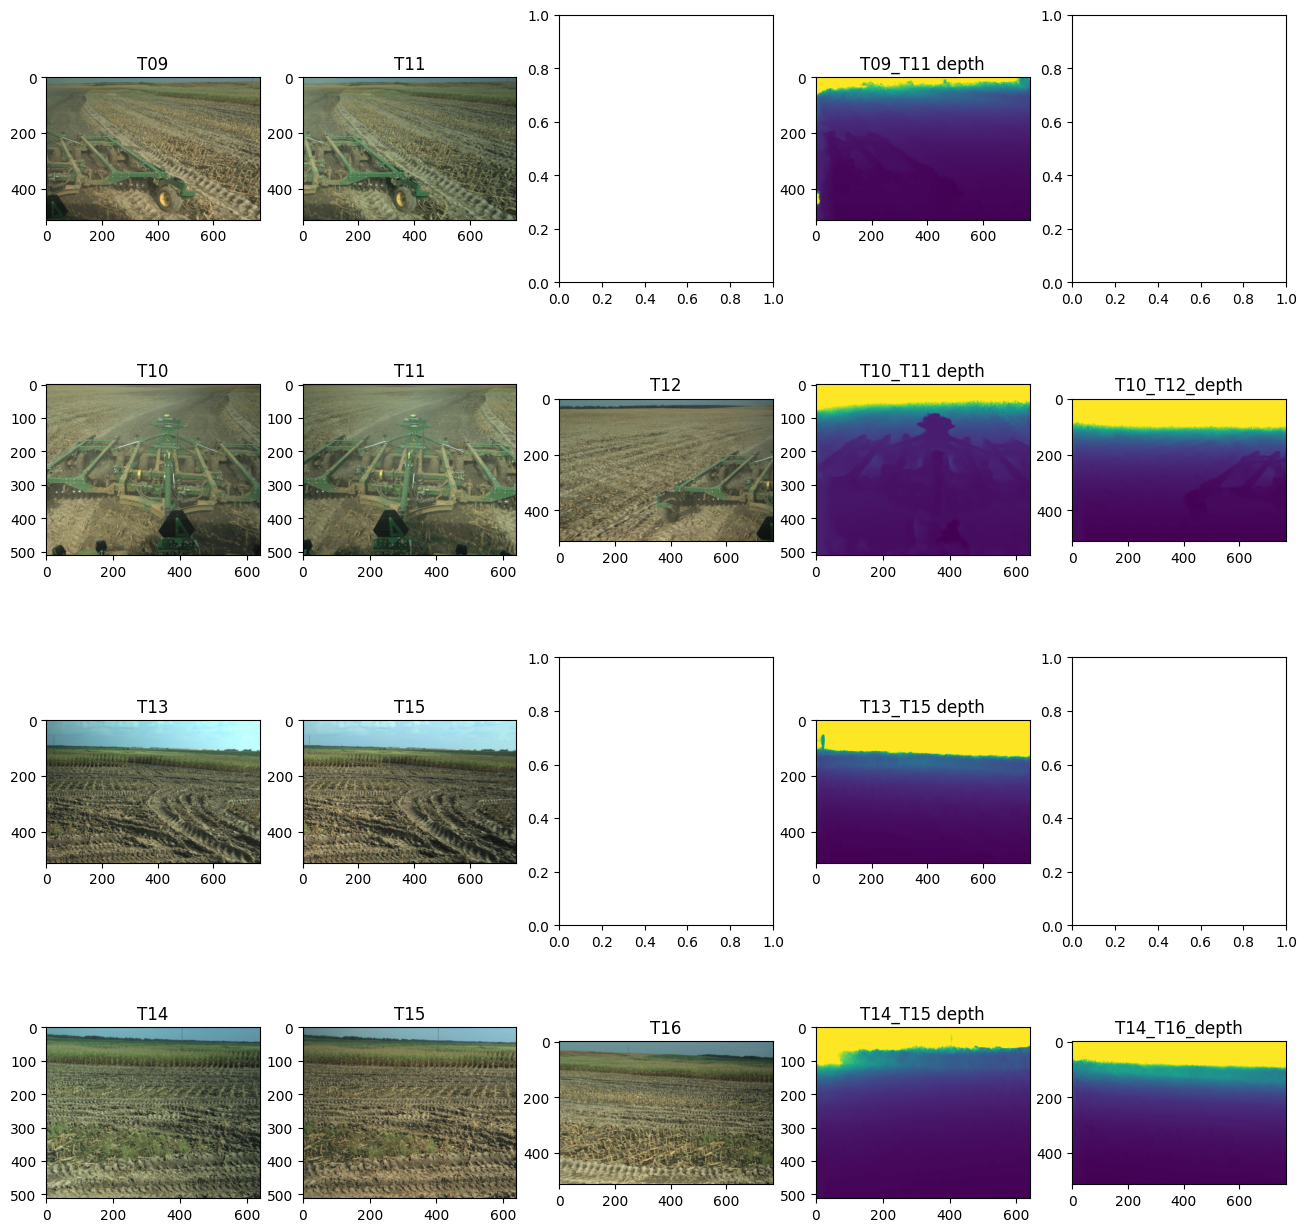

In [20]:
%matplotlib inline
show_images(stereo_df)

In [30]:
obj = load_object(stereo_df.iloc[0])
obj[0][0]['rectified_calibration_data'].tolist()['R1']

[0.7521172178781224,
 -0.18670491563532254,
 0.6320292438241132,
 0.19724934495849147,
 0.9788413193129066,
 0.0544276356202824,
 -0.6288182459858487,
 0.08373139246050602,
 0.7730308321353717]

In [37]:
obj[0][0]['point_cloud'][15:-15, 15:-15]

array([[[ 112.46 , -150.   ,  100.   ],
        [ 109.354, -150.   ,  100.   ],
        [ 111.14 , -150.   ,  100.   ],
        ...,
        [  64.365,  -22.476,   52.675],
        [  64.468,  -22.484,   52.695],
        [  64.595,  -22.501,   52.735]],

       [[ 115.84 , -150.   ,  100.   ],
        [ 116.493, -150.   ,  100.   ],
        [ 117.706, -150.   ,  100.   ],
        ...,
        [  64.291,  -22.372,   52.614],
        [  64.482,  -22.411,   52.706],
        [  64.607,  -22.427,   52.744]],

       [[ 116.131, -150.   ,  100.   ],
        [ 116.961, -150.   ,  100.   ],
        [ 118.204, -150.   ,  100.   ],
        ...,
        [  64.229,  -22.272,   52.563],
        [  64.538,  -22.352,   52.752],
        [  64.544,  -22.327,   52.693]],

       ...,

       [[   1.526,    3.329,   11.696],
        [   1.485,    3.202,   11.251],
        [   1.49 ,    3.179,   11.168],
        ...,
        [   6.382,    1.486,    5.223],
        [   6.386,    1.486,    5.22 ],
        [

In [22]:
# 0) pixel coordinates. Reindex with the k matrix (approx to) ([-1,1], [-1,1])
# rectifed camera space
# 1) do a backward distortion (as is typical). Still 2d + homo
# 
# 2) Convert to 3d with the extrinsic matrix (Try with both pods, one should be OK)
# OCAL: 
# Ask atul or pablo about what ocal vs calibration data is
# go with calibration data for now
# calibration_data: Factory set camera parameters for a camera pair/pod. Do not get adjusted
# ocal: detects minor shifts over time to update the calibration data

# Depth of each point is a scaling factor 

In [23]:
# rectification 
# https://github.com/BlueRiverTechnology/JupiterLibs/blob/0e1d003a61c00b28a53066dbe2dbcfd8c584490c/src/jupiter_vision/py_interface/image_processor.cpp#L364

In [24]:
def load_intrinsic(calibration, img_shape):
    cam_intrinsics = open3d.camera.PinholeCameraIntrinsic()
    cam_intrinsics.intrinsic_matrix = np.array(calibration['intrinsics']['k']).reshape(3,3)
    cam_intrinsics.height = img_shape[0]
    cam_intrinsics.width = img_shape[1]
    return cam_intrinsics


# def load_cam_to_world(calibration):
#     extrinsic_matrix = load_extrinsic(calibration)
#     cam_to_world = np.linalg.inv(extrinsic_matrix)
#     def convert(pointcloud):
#         pointcloud_4d = np.concatenate([pointcloud, np.ones((pointcloud.shape[0], 1))], axis=1)
#         pointcloud_world_coords = (cam_to_world @ pointcloud_4d.T).T
#         return pointcloud_world_coords[:, :3] / pointcloud_world_coords[:, 3:]
#     return convert
def load_extrinsic(calibration):
    extrinsics = calibration['extrinsics']
    r = cv2.Rodrigues(np.array(extrinsics['r_rodrigues']))[0]
    t = np.array(extrinsics['t']).reshape(3,1)
    extrinsic_matrix = np.concatenate([r, t], axis=1)
    return np.concatenate([extrinsic_matrix, np.array([0,0,0,1]).reshape(1,4)], axis=0)


In [26]:
# def load_rgbd_image(obj, intensity_only=False):
#     d_np = depth_from_point_cloud(obj['point_cloud'], clip_and_normalize=False)
#     d = open3d.geometry.Image((d_np * 256).astype(np.float32))
#     rgb_np = normalize_image(obj['left'], hdr_mode=True)
#     rgb = open3d.geometry.Image(rgb_np)
#     return open3d.geometry.RGBDImage.create_from_color_and_depth(rgb, d, convert_rgb_to_intensity=intensity_only)
def load_pointcloud(row, obj):
    calibration = ast.literal_eval(row['online_calibration_results'])

    rot = obj["rectified_calibration_data"].tolist()['R1']
    rot = np.array(rot).reshape(3, 3)
    rot_inv = np.linalg.inv(rot)
    point_cloud = obj['point_cloud'].reshape(-1, 3)
    point_cloud = (rot_inv @ point_cloud.T).T

    pts = open3d.geometry.PointCloud()
    pts.points = open3d.utility.Vector3dVector(point_cloud)
    cam_extrinsics = load_extrinsic(calibration)
    pts.transform(np.linalg.inv(cam_extrinsics))
    return pts
    # return open3d.geometry.PointCloud.create_from_rgbd_image(rgbd, cam_intrinsics, extrinsic=cam_extrinsics)

In [1]:
pcs = []
colors = []
left_images = []
for (k, row) in  stereo_df.iterrows():
    for obj, cams, label in load_object(row, get_label=True):
        print(cams)
        if cams[0] in ['T09', 'T10']:
            pc = load_pointcloud(row, obj)
            pcs.append(pc)
            left_images.append(obj['left'].reshape(-1, 3))
left_images = np.concatenate(left_images, axis=0)
# Normalize them all together so they have the same tonemapping
left_rgb = normalize_image(left_images, hdr_mode=True)
colors.append(left_rgb.reshape(-1, 3))
# for pc in pcs:
#     pc.estimate_normals()
# pose_graph = full_registration(pcs, 0.1, max_correspondence_distance_coarse=1.0)
# for i in range(len(pcs)):
#     pcs[i].transform(pose_graph.nodes[i].pose)

full_pc = open3d.geometry.PointCloud()
for pc in pcs:
    full_pc += pc
full_pc.colors = open3d.utility.Vector3dVector(np.concatenate(colors, axis=0))    
viewer = open3d.visualization.Visualizer()
viewer.create_window()
viewer.add_geometry(full_pc)
opt = viewer.get_render_option()
opt.show_coordinate_frame = True
opt.background_color = np.asarray([0.5, 0.5, 0.5])
viewer.run()
viewer.destroy_window()

# open3d.visualization.draw_geometries([full_pc])

NameError: name 'stereo_df' is not defined

In [42]:
np.asarray(full_pc.points)

array([[-139.90136462,  118.04555737,  102.0465517 ],
       [-139.83751991,  118.9996305 ,  102.00758098],
       [-139.77420913,  119.94572488,  101.96893616],
       ...,
       [  -7.04539793,   -0.86672737,   -3.94453642],
       [  -7.02432831,   -0.85619858,   -3.92822025],
       [  -7.00236716,   -0.84461828,   -3.91158889]])

In [28]:
from dl.config.label_map_helper import LabelMapHelper, LabelConversion
label_file = "/home/alexli/git/JupiterCVML/europa/base/src/europa/dl/config/label_maps/seven_class_train.csv"
merged_pointcloud = []
color_by_image = []
color_by_camera = []
color_by_label = []
color_choices_cam = get_distinct_colors(len(stereo_df))
label_map_helper = LabelMapHelper(label_file)
label_converter = LabelConversion(label_map_helper)
color_choices_label = get_distinct_colors(label_map_helper.get_num_train_classes() + 1)
for color, (_, row) in zip(color_choices_cam, stereo_df.iterrows()):
    for obj, cams, label in load_object(row, get_label=True):
        im = normalize_image(obj['left'], hdr_mode=True)[:, :, :].reshape(-1,  obj['left'].shape[2])
        label = label_converter.convert_label_for_driveable_terrain(label, json.loads(row['label_map'])).reshape(-1)
        pc = obj['point_cloud'].reshape(-1,  obj['point_cloud'].shape[2])
        calibration = ast.literal_eval(row['calibration_data'])
        cam_to_world = load_cam_to_world(calibration=calibration)
        merged_pointcloud.append(cam_to_world(pc))
        color_by_image.append(im)
        color_by_camera.append([color for _ in range(pc.shape[0])])
        color_by_label.append([color_choices_label[l + 1] if l != 255 else color_choices_label[0] for l in label])
merged_pointcloud = np.concatenate(merged_pointcloud, axis=0)
color_by_camera = np.concatenate(color_by_camera, axis=0)
color_by_image = np.concatenate(color_by_image, axis=0)
color_by_label = np.concatenate(color_by_label, axis=0)

In [ ]:
merged_pointcloud.shape

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(merged_pointcloud)
pcd.colors = o3d.utility.Vector3dVector(color_by_label)
o3d.visualization.draw_geometries([pcd])

In [ ]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.2)
o3d.visualization.draw_geometries([voxel_grid])


In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure(
#     data=[
#         go.Scatter3d(
#             x=pcs[:,0], y=pcs[:,1], z=pcs[:,2], 
#             mode='markers',
#             marker=dict(size=1, color=[list_to_plotly_color(c) for c in color_by_camera])
#         )
#     ],
#     # layout=dict(
#     #     scene=dict(
#     #         xaxis=dict(visible=False),
#     #         yaxis=dict(visible=False),
#     #         zaxis=dict(visible=False)
#     #     )
#     # )
# )
# fig.show()